In [3]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam


In [78]:
import os
import random
import shutil

# Path ke folder dataset Anda
base_dir = r"D:\Semester 3\Kecerdasan Buatan (CERTAN)\Week 16\Proyek\DataSet\archive\dataset"
men_dir = os.path.join(base_dir, "MEN")
women_dir = os.path.join(base_dir, "WOMAN")

# Output folder untuk training dan validation
train_dir_men = os.path.join(base_dir, "MEN_train")
val_dir_men = os.path.join(base_dir, "MEN_val")
train_dir_women = os.path.join(base_dir, "WOMAN_train")
val_dir_women = os.path.join(base_dir, "WOMAN_val")

# Membuat folder output jika belum ada
os.makedirs(train_dir_men, exist_ok=True)
os.makedirs(val_dir_men, exist_ok=True)
os.makedirs(train_dir_women, exist_ok=True)
os.makedirs(val_dir_women, exist_ok=True)

# Fungsi untuk membagi dataset menjadi training dan validation
def split_dataset(source_dir, train_dir, val_dir, train_size, val_size):
    # Daftar semua file di source_dir
    all_files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    # Acak urutan file
    random.shuffle(all_files)
    # Membagi file menjadi training dan validation
    train_files = all_files[:train_size]
    val_files = all_files[train_size:train_size + val_size]
    
    # Menyalin file ke folder training
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))
    # Menyalin file ke folder validation
    for file in val_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(val_dir, file))

# Membagi dataset MEN
split_dataset(men_dir, train_dir_men, val_dir_men, 480, 120)

# Membagi dataset WOMEN
split_dataset(women_dir, train_dir_women, val_dir_women, 480, 120)

print("Proses pembagian dataset selesai. Training dan validation sudah dibuat.")


Proses pembagian dataset selesai. Training dan validation sudah dibuat.


In [80]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,  # Rotasi gambar
    width_shift_range=0.2,  # Perpindahan horizontal
    height_shift_range=0.2,  # Perpindahan vertikal
    shear_range=0.2,  # Distorsi shearing
    zoom_range=0.2,  # Zoom in dan zoom out
    horizontal_flip=True,  # Membalik gambar secara horizontal
    fill_mode='nearest'  # Menangani area kosong akibat augmentasi
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [82]:
batch_size = 64
target_size = (64, 64)
input_shape=(64, 64, 3)
seed=1337
adam = 0.001
fre= -20
FC = 2048
E = 1
patience = 3
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch=256
validation_steps=256
epochs=8

In [84]:
train_generator = train_datagen.flow_from_directory(
    'D:\\Semester 3\\Kecerdasan Buatan (CERTAN)\\Week 16\\Proyek\\DataSet\\archive\\dataset\\Train',
    batch_size=batch_size,
    class_mode='binary',
    seed=seed,
    target_size=target_size
)

validation_generator = test_datagen.flow_from_directory(
    'D:\\Semester 3\\Kecerdasan Buatan (CERTAN)\\Week 16\\Proyek\\DataSet\\archive\\dataset\\Validation',
    batch_size=batch_size,
    class_mode='binary',
    seed=seed,
    target_size=target_size
)


Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [86]:
base_model = tf.keras.applications.VGG16(input_shape=input_shape,include_top=False,weights="imagenet")

In [88]:
# Freezing Layers

for layer in base_model.layers[:fre]:
    layer.trainable=False

In [90]:
# Building Model
model=Sequential()
model.add(base_model)
model.add(layers.Dropout(.2))

model.add(Conv2D(512, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(128, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(384, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Dropout(.1))
model.add(Conv2D(500, (3, 3),strides=(1,1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,strides=(2,2), padding='same'))



# Add new layers
model.add(Flatten())
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC , activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(FC, activation='relu'))
model.add(layers.Dropout(.2))
model.add(Dense(E, activation='sigmoid'))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 2, 2, 128)           │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 2, 2, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 2, 2, 384)           │         442,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 2, 2, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 2, 2, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 2, 2, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 2, 2, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 2, 2, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 2, 2, 500)           │       1,728,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 2, 2, 500)           │           2,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 500)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2048)                │       1,026,0

 Total params: 30,591,621 (116.70 MB)

 Trainable params: 30,587,805 (116.68 MB)

 Non-trainable params: 3,816 (14.91 KB)

In [92]:
# Callback untuk pelatihan
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Callback untuk menurunkan learning rate secara adaptif
lrd = ReduceLROnPlateau(
    monitor='val_loss',
    patience=patience,
    verbose=verbose,
    factor=factor,
    min_lr=min_lr
)

# Callback untuk menyimpan model terbaik selama pelatihan
mcp = ModelCheckpoint(
    'model.keras',  # Format terbaru untuk file model
    monitor='val_loss',
    save_best_only=True,
    verbose=verbose
)

# Callback untuk menghentikan pelatihan lebih awal jika tidak ada peningkatan
es = EarlyStopping(
    verbose=verbose,
    patience=patience
)


In [98]:
# Compile model sebelum training
model.compile(
    optimizer='adam',                # Pilihan optimizer (misal: 'adam', 'sgd', dll.)
    loss='binary_crossentropy',      # Fungsi loss (ubah sesuai kebutuhan)
    metrics=['accuracy']             # Metrik evaluasi
)

%time
hist = model.fit(
    train_generator,                 # Generator untuk data pelatihan
    validation_data=validation_generator,  # Generator untuk data validasi
    steps_per_epoch=steps_per_epoch,  # Langkah per epoch
    validation_steps=validation_steps, # Langkah validasi
    epochs=epochs,                   # Jumlah epoch
    callbacks=[lrd, mcp, es]         # Callback untuk pelatihan
)




CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/8
 15/256 ━━━━━━━━━━━━━━━━━━━━ 10:52 3s/step - accuracy: 0.6375 - loss: 0.6492
Epoch 1: val_loss improved from 0.67019 to 0.62601, saving model to model.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 64s 197ms/step - accuracy: 0.6071 - loss: 0.6604 - val_accuracy: 0.6125 - val_loss: 0.6260 - learning_rate: 0.0010
Epoch 2/8
 15/256 ━━━━━━━━━━━━━━━━━━━━ 10:20 3s/step - accuracy: 0.6656 - loss: 0.6369
Epoch 2: val_loss improved from 0.62601 to 0.61891, saving model to model.keras
256/256 ━━━━━━━━━━━━━━━━━━━━ 50s 183ms/step - accuracy: 0.6764 - loss: 0.6282 - val_accuracy: 0.6750 - val_loss: 0.6189 - learning_rate: 0.0010
Epoch 3/8
 15/256 ━━━━━━━━━━━━━━━━━━━━ 11:47 3s/step - accuracy: 0.7059 - loss: 0.5789
Epoch 3: val_loss did not improve from 0.61891
256/256 ━━━━━━━━━━━━━━━━━━━━ 52s 187ms/step - accuracy: 0.7043 - loss: 0.5815 - val_accuracy: 0.5000 - val_loss: 20.0366 - learning_rate: 0.0010
Epoch 4/8
 15/256 ━━━━━━━━━━━━━━━━━━━━ 9:57 2s/step - accura

In [105]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


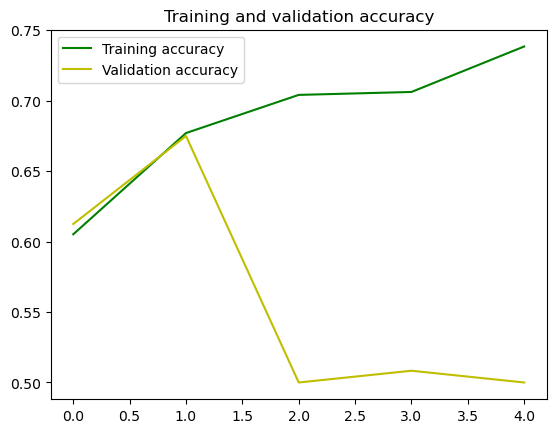

<Figure size 640x480 with 0 Axes>

In [102]:
import matplotlib.pyplot as plt
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'y', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
import numpy as np

from keras.preprocessing import image
#  images test 1
path_testmodel = "../input/testmodel/test1.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]<0.5:
    print("This is a male")
else:
    print( "This  is a female")
plt.imshow(imge)

In [ ]:
import numpy as np

from keras.preprocessing import image
#  images test 2
path_testmodel = "../input/testmodel/test2.jpg"
imge = image.load_img(path_testmodel, target_size=target_size)
X = image.img_to_array(imge)
X = np.expand_dims(X, axis=0)

images = np.vstack([X])
classes = model.predict(images, batch_size=1)
print(classes[0])
if classes[0]>0.5:
    print("This is a male")
else:
    print( "This is a female")
plt.imshow(imge)